In [8]:
import numpy as np
import pandas as pd
import yfinance as download
from sklearn.preprocessing import MinMaxScaler
import torch

# 1. Scarichiamo i dati
data = download.download('BTC-USD', start='2020-01-01', end='2023-12-31')
prices = data['Close'].values.reshape(-1, 1)

# 2. Normalizzazione: Fondamentale! Le reti neurali odiano i numeri grandi (es. 60.000$)
# Scaliamo tutto tra 0 e 1.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# 3. Creazione delle sequenze (Lookback)
# Usiamo gli ultimi 60 giorni per predire il 61°
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length]) # Gli ultimi 60 giorni
        y.append(data[i+seq_length])    # Il prezzo target (domani)
    return np.array(x), np.array(y)

X, y = create_sequences(scaled_prices, 60)

# Trasformiamo i dati in TENSORI di PyTorch
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

print(f"Forma di X: {X.shape}") # Output: [Esempi, 60, 1] -> 1 è la feature (Close)

[*********************100%***********************]  1 of 1 completed

Forma di X: torch.Size([1400, 60, 1])


In [9]:
import torch.nn as nn

class TradingModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TradingModel, self).__init__() #È una riga "magica" obbligatoria. Dice a Python: "Prendi tutto ciò che PyTorch sa fare con le reti neurali e passalo a questa mia classe".
        
        # L'anima del modello: LSTM
        # input_size: quante feature passiamo (qui solo 1: il prezzo Close)
        # hidden_size: quanti "neuroni" o memoria interna
        # batch_first=True: dice a PyTorch che il primo numero della forma è il numero di esempi
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Il livello di uscita: un "Linear" (o Fully Connected)
        # Prende i risultati della LSTM e li trasforma in 1 singolo numero (il prezzo predetto)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # 1. Passiamo i dati attraverso la LSTM
        # out contiene l'output di ogni step temporale
        # _ contiene lo "stato interno" che qui non ci serve
        out, _ = self.lstm(x)
        
        # 2. Prendiamo solo l'ultimo step (il giorno 60) per fare la previsione
        # out[:, -1, :] significa: tutti gli esempi, l'ultimo giorno, tutte le memorie
        out = self.fc(out[:, -1, :])
        return out

# Inizializziamo il modello
model = TradingModel(input_size=1, hidden_size=64, num_layers=2)

In [10]:
import torch.optim as optim

# Parametri
learning_rate = 0.001
epochs = 100 # Quante volte il modello vede l'intero dataset

# Inizializziamo Loss e Optimizer
criterion = torch.nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- CICLO DI ALLENAMENTO ---
for epoch in range(epochs):
    model.train() # Mettiamo il modello in modalità addestramento
    
    # 1. Reset dei gradienti (fondamentale in PyTorch)
    optimizer.zero_grad()
    
    # 2. Forward pass: il modello fa una previsione
    outputs = model(X)
    
    # 3. Calcolo dell'errore
    loss = criterion(outputs, y)
    
    # 4. Backpropagation: calcola come cambiare i pesi per sbagliare meno
    loss.backward()
    
    # 5. Step dell'ottimizzatore: applica i cambiamenti
    optimizer.step()
    
    # Stampiamo il progresso ogni 10 epoche
    if (epoch+1) % 10 == 0:
        print(f'Epoca [{epoch+1}/{epochs}], Errore (Loss): {loss.item():.6f}')

print("Allenamento completato!")

Epoca [10/100], Errore (Loss): 0.090785
Epoca [20/100], Errore (Loss): 0.049723
Epoca [30/100], Errore (Loss): 0.046334
Epoca [40/100], Errore (Loss): 0.034644
Epoca [50/100], Errore (Loss): 0.013483
Epoca [60/100], Errore (Loss): 0.008151
Epoca [70/100], Errore (Loss): 0.005052
Epoca [80/100], Errore (Loss): 0.003776
Epoca [90/100], Errore (Loss): 0.002983
Epoca [100/100], Errore (Loss): 0.002443
Allenamento completato!


TEST SERIO CON DATA LOADER PIU' REALISTICO, CON TRAIN DAL 2020 AL 2022 E TEST DAL 2023.

In [17]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch

# 1. Scarichiamo i dati completi
df = yf.download('BTC-USD', start='2018-01-01', end='2025-12-30')

# 2. Split temporale
train_df = df[df.index < '2023-01-01'] # 2020, 2021, 2022
test_df = df[df.index >= '2023-01-01'] # 2023

# 3. Normalizzazione (Fondamentale!)
scaler = MinMaxScaler(feature_range=(0, 1))
# Impariamo i parametri (min/max) SOLO dal train
train_scaled = scaler.fit_transform(train_df['Close'].values.reshape(-1, 1))
# Applichiamo gli stessi parametri al test (senza fargli vedere i nuovi massimi/minimi)
test_scaled = scaler.transform(test_df['Close'].values.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed


In [18]:
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.tensor(x).float(), torch.tensor(y).float()

seq_length = 60
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# Creiamo i dataset PyTorch
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Creiamo i DataLoader
# shuffle=True per il train aiuta il modello a non imparare l'ordine cronologico delle finestre
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Per il test non serve mescolare
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# Inizializziamo modello, perdita e ottimizzatore (come prima)
model = TradingModel(input_size=1, hidden_size=64, num_layers=2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50 

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoca {epoch+1}/{epochs} - Errore medio: {running_loss/len(train_loader):.6f}")

Epoca 10/50 - Errore medio: 0.000791
Epoca 20/50 - Errore medio: 0.000539
Epoca 30/50 - Errore medio: 0.000422
Epoca 40/50 - Errore medio: 0.000370
Epoca 50/50 - Errore medio: 0.000361


In [20]:
model.eval() # Modalità valutazione
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.append(outputs.numpy())
        actuals.append(batch_y.numpy())

# Trasformiamo tutto in array normali
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Riportiamo i prezzi ai valori reali ($) invertendo la normalizzazione
predictions_dollars = scaler.inverse_transform(predictions)
actuals_dollars = scaler.inverse_transform(actuals)

Errore Medio Assoluto (MAE): 1562.67 USD


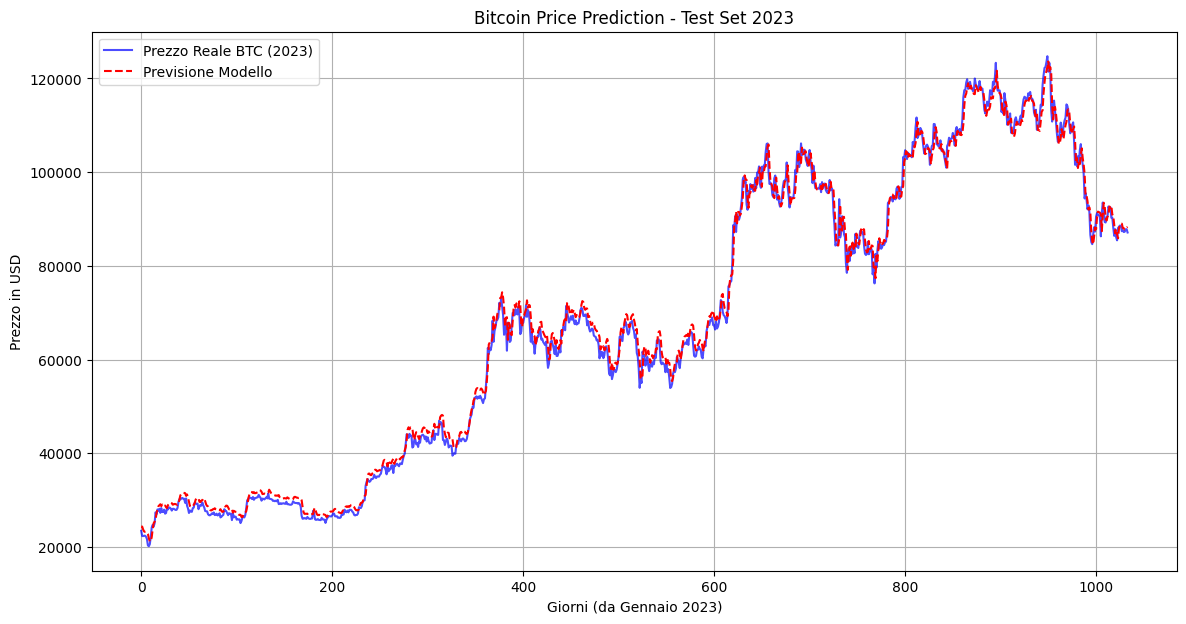

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. Calcoliamo l'errore medio in dollari (MAE)
# Ci dice mediamente di quanti dollari il modello ha sbagliato ogni giorno
mae = mean_absolute_error(actuals_dollars, predictions_dollars)
print(f"Errore Medio Assoluto (MAE): {mae:.2f} USD")

# 2. Creazione del Grafico
plt.figure(figsize=(14, 7))

# Prezzi Reali
plt.plot(actuals_dollars, label='Prezzo Reale BTC (2023)', color='blue', alpha=0.7)

# Previsioni del Modello
plt.plot(predictions_dollars, label='Previsione Modello', color='red', linestyle='--')

plt.title('Bitcoin Price Prediction - Test Set 2023')
plt.xlabel('Giorni (da Gennaio 2023)')
plt.ylabel('Prezzo in USD')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def calculate_indicators(df):

    df = yf.download('BTC-USD', start='2020-01-01', end='2023-12-31')
    
    # 1. SMA (Simple Moving Average) - Facile
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    # 2. Volatilità (Standard Deviation)
    df['Volatilità'] = df['Close'].rolling(window=20).std()
    
    # 3. RSI (Relative Strength Index) - Formula standard di Wilder
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df.dropna(inplace=True) # Rimuove le righe dove gli indicatori non sono ancora calcolabili
    return df

# Applichiamo le funzioni
df = calculate_indicators(df)
features = ['Close', 'RSI', 'SMA_20', 'Volatilità']
data_subset = df[features].values

# --- 2. SPLIT E NORMALIZZAZIONE ---
# Dividiamo prima di scalare per evitare Data Leakage
train_df = df[df.index < '2023-01-01'].copy()
test_df = df[df.index >= '2023-01-01'].copy()

features = ['Close', 'RSI', 'SMA_20', 'Volatilità']

# Scaler per gli Input (tutte e 4 le feature)
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_x_scaled = scaler_x.fit_transform(train_df[features])
test_x_scaled = scaler_x.transform(test_df[features])

# Scaler per l'Output (solo il Close) - serve per tornare in dollari facilmente
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y_scaled = scaler_y.fit_transform(train_df[['Close']])
test_y_scaled = scaler_y.transform(test_df[['Close']])

[*********************100%***********************]  1 of 1 completed


In [26]:
# --- 3. CREAZIONE SEQUENZE ---
def create_sequences(data_x, data_y, seq_length):
    x, y = [], []
    for i in range(len(data_x) - seq_length):
        x.append(data_x[i:i+seq_length])
        y.append(data_y[i+seq_length])
    return torch.tensor(np.array(x)).float(), torch.tensor(np.array(y)).float()

seq_length = 60
X_train, y_train = create_sequences(train_x_scaled, train_y_scaled, seq_length)
X_test, y_test = create_sequences(test_x_scaled, test_y_scaled, seq_length)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

In [27]:
# --- 4. DEFINIZIONE MODELLO ---
class TradingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TradingLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Prendiamo l'ultimo giorno della sequenza
        return out

model = TradingLSTM(input_size=4, hidden_size=64, num_layers=2)

In [28]:
# --- 5. TRAINING LOOP ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Inizio allenamento...")
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoca {epoch+1}/50, Loss: {total_loss/len(train_loader):.6f}")

Inizio allenamento...
Epoca 10/50, Loss: 0.001358
Epoca 20/50, Loss: 0.000834
Epoca 30/50, Loss: 0.000663
Epoca 40/50, Loss: 0.000629
Epoca 50/50, Loss: 0.000556


--- RISULTATI TEST 2023 ---
MAE:  708.64 USD  (Errore medio giornaliero)
MSE:  865091.06 USD  (Errore quadraticomedio giornaliero)
RMSE: 930.10 USD (Penalizza i grandi errori)


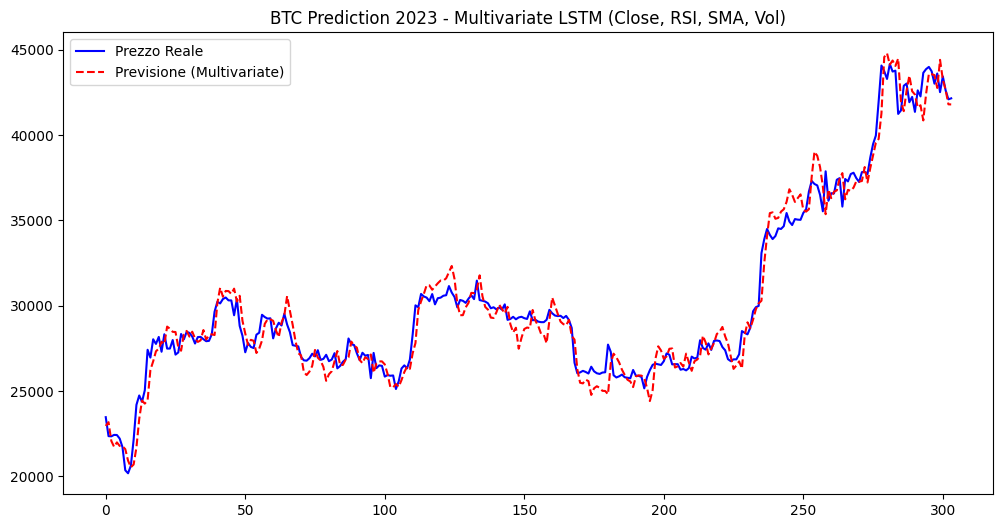

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 6. VALUTAZIONE E PLOT ---
model.eval()
predictions = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        outputs = model(batch_X)
        predictions.append(outputs.numpy())

predictions = np.concatenate(predictions)

# Riportiamo in dollari
predictions_usd = scaler_y.inverse_transform(predictions)
actual_usd = scaler_y.inverse_transform(y_test.numpy())

# 1. Calcolo MAE (Errore medio in dollari)
mae = mean_absolute_error(actual_usd, predictions_usd)

# 2. Calcolo MSE
mse = mean_squared_error(actual_usd, predictions_usd)

# 3. Calcolo RMSE (La radice dell'MSE)
rmse = np.sqrt(mse)

print(f"--- RISULTATI TEST 2023 ---")
print(f"MAE:  {mae:.2f} USD  (Errore medio giornaliero)")
print(f"MSE:  {mse:.2f} USD  (Errore quadraticomedio giornaliero)")
print(f"RMSE: {rmse:.2f} USD (Penalizza i grandi errori)")

# Grafico
plt.figure(figsize=(12,6))
plt.plot(actual_usd, label='Prezzo Reale', color='blue')
plt.plot(predictions_usd, label='Previsione (Multivariate)', color='red', linestyle='--')
plt.title('BTC Prediction 2023 - Multivariate LSTM (Close, RSI, SMA, Vol)')
plt.legend()
plt.show()

Smettere di predire il prezzo e iniziare a predire i rendimenti (Log Returns).

In [79]:
from sklearn.preprocessing import StandardScaler

# --- 1. MODIFICA CALCOLO DATI (Aggiungiamo Log Returns) ---
def get_quant_data():
    df = yf.download('CL=F', start='2020-01-01', end='2025-12-30')
    
    # Il nostro TARGET: Rendimento Logaritmico
    # Formula: log(Prezzo_t / Prezzo_t-1)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Indicatori (Feature)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['Volatilità'] = df['Log_Return'].rolling(window=20).std() # Volatilità dei rendimenti
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    df.dropna(inplace=True)
    return df

df = get_quant_data()

# --- 2. SETUP FEATURES E TARGET ---
# Feature: Prezzo, RSI, SMA, Volatilità
# Target: Log_Return (Quello che vogliamo prevedere)

train_df = df[df.index < '2023-01-01'].copy()
test_df = df[df.index >= '2023-01-01'].copy()

features = ['Close', 'RSI', 'SMA_20', 'Volatilità']
target = ['Log_Return']

# --- 2. SPLIT E NORMALIZZAZIONE ---
# StandardScaler è spesso migliore per i rendimenti (distribuzione quasi gaussiana)
scaler_x = StandardScaler()
scaler_y = StandardScaler()

train_x_scaled = scaler_x.fit_transform(train_df[features])
train_y_scaled = scaler_y.fit_transform(train_df[target])

test_x_scaled = scaler_x.transform(test_df[features])
test_y_scaled = scaler_y.transform(test_df[target])


[*********************100%***********************]  1 of 1 completed
/Users/paolo13/Desktop/Python Finance/DL/.venv/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [80]:
# --- 4. CREAZIONE SEQUENZE ---
def create_sequences(data_x, data_y, seq_length):
    x, y = [], []
    for i in range(len(data_x) - seq_length):
        x.append(data_x[i:i+seq_length])
        y.append(data_y[i+seq_length])
    return torch.tensor(np.array(x)).float(), torch.tensor(np.array(y)).float()

seq_length = 30 # Usiamo 30 giorni per predire il rendimento del giorno dopo
X_train, y_train = create_sequences(train_x_scaled, train_y_scaled, seq_length)
X_test, y_test = create_sequences(test_x_scaled, test_y_scaled, seq_length)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

In [81]:
# --- 5. ARCHITETTURA LSTM ---
class QuantLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(QuantLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = QuantLSTM(input_size=4, hidden_size=64, num_layers=2)

In [82]:
# --- 6. TRAINING ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

print("Training in corso...")
model.train()
for epoch in range(60):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(batch_X), batch_y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/60 | Loss: {loss.item():.6f}")

Training in corso...
Epoch 10/60 | Loss: 1.167574
Epoch 20/60 | Loss: 0.278052
Epoch 30/60 | Loss: 1.288801
Epoch 40/60 | Loss: 4.227859
Epoch 50/60 | Loss: 1.165935
Epoch 60/60 | Loss: 0.477455



--- PERFORMANCE TEST SET (2023) ---
MAE: 0.015485 (Errore medio rendimento)
RMSE: 0.020061
Directional Accuracy: 51.66%


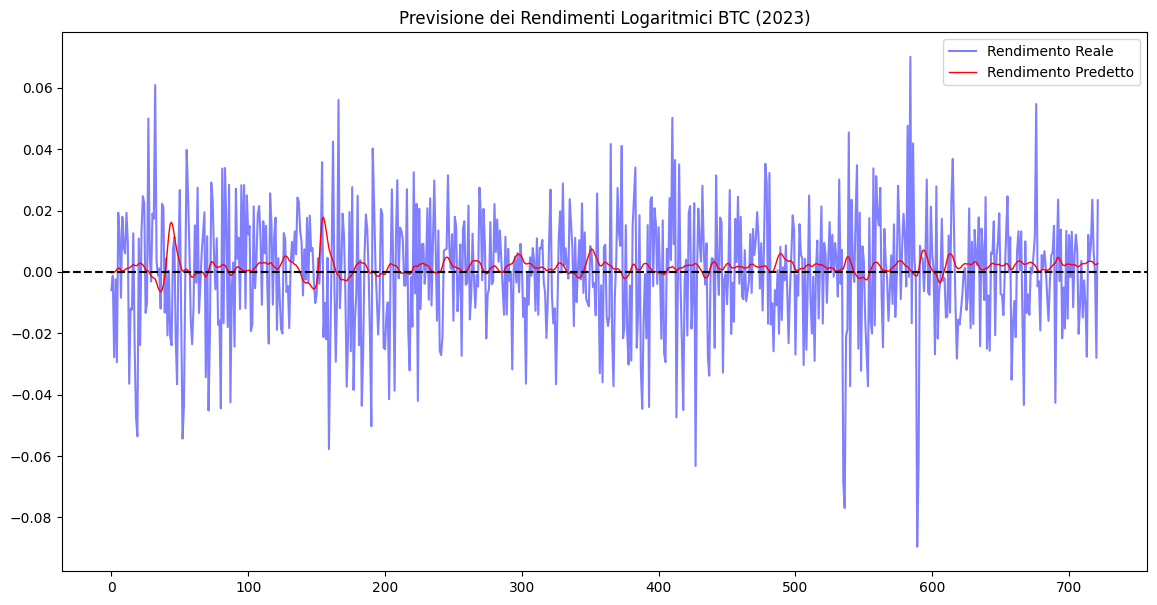

In [83]:
# --- 7. VALUTAZIONE PROFESSIONALE ---
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).numpy()

# Invertiamo la scala per tornare ai rendimenti logaritmici reali
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
y_test_log = scaler_y.inverse_transform(y_test.numpy())

mae = mean_absolute_error(y_test_log, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

# Directional Accuracy (Hit Rate)
# Quante volte il segno predetto è uguale al segno reale?
correct_direction = (np.sign(y_pred_log) == np.sign(y_test_log)).sum()
hit_rate = (correct_direction / len(y_test_log)) * 100

print(f"\n--- PERFORMANCE TEST SET (2023) ---")
print(f"MAE: {mae:.6f} (Errore medio rendimento)")
print(f"RMSE: {rmse:.6f}")
print(f"Directional Accuracy: {hit_rate:.2f}%")

# --- 8. PLOT DEI RENDIMENTI ---
plt.figure(figsize=(14,7))
plt.plot(y_test_log, label='Rendimento Reale', color='blue', alpha=0.5)
plt.plot(y_pred_log, label='Rendimento Predetto', color='red', lw=1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Previsione dei Rendimenti Logaritmici BTC (2023)')
plt.legend()
plt.show()

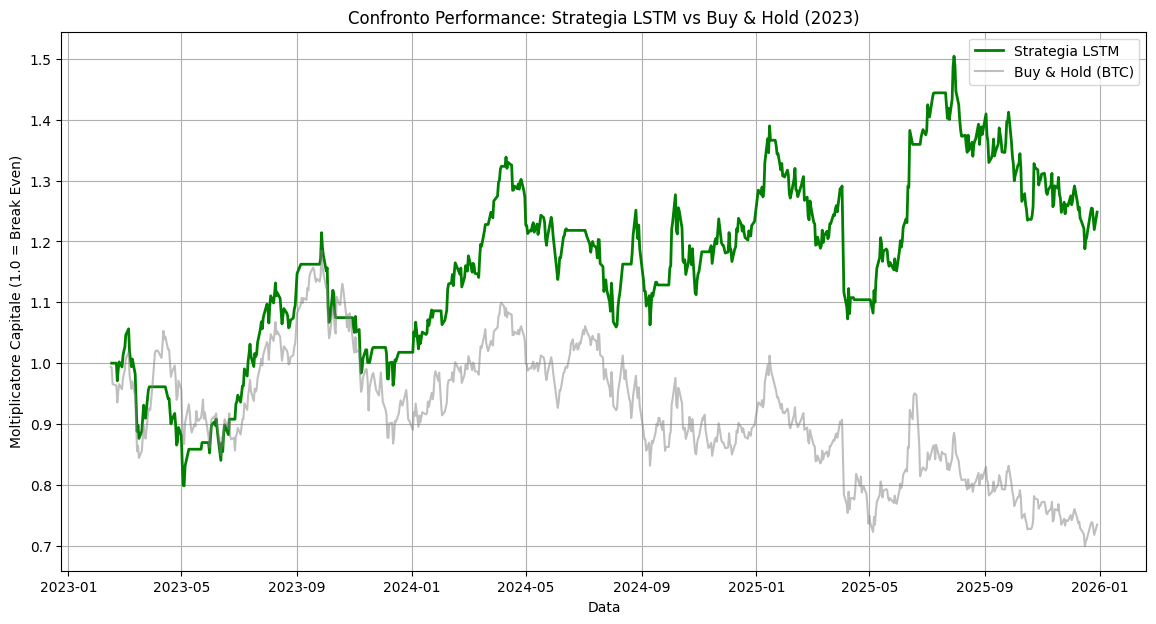

--- RISULTATI BACKTEST ---
Rendimento Finale Strategia: 24.83%
Rendimento Finale Buy & Hold: -26.54%


In [84]:
# --- 9. BACKTEST DELLA STRATEGIA ---

# Creiamo un DataFrame per il backtest
backtest_df = pd.DataFrame({
    'Rendimento_Reale': y_test_log.flatten(),
    'Previsione_Modello': y_pred_log.flatten()
}, index=test_df.index[seq_length:])

# Generiamo i segnali: 1 se la previsione è positiva, 0 altrimenti
backtest_df['Segnale'] = np.where(backtest_df['Previsione_Modello'] > 0, 1, 0)

# Calcoliamo i rendimenti della strategia
# Moltiplichiamo il segnale di "oggi" per il rendimento "reale" di domani
# Nota: usiamo shift(1) sui segnali per evitare di guardare il futuro
backtest_df['Rendimento_Strategia'] = backtest_df['Segnale'].shift(1) * backtest_df['Rendimento_Reale']

# Calcoliamo i rendimenti cumulati (Equity Curve)
# Usiamo exp() perché abbiamo lavorato con i Log Returns
backtest_df['Equity_Strategia'] = np.exp(backtest_df['Rendimento_Strategia'].cumsum())
backtest_df['Equity_BuyHold'] = np.exp(backtest_df['Rendimento_Reale'].cumsum())

# --- 10. VISUALIZZAZIONE PERFORMANCE ---
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['Equity_Strategia'], label='Strategia LSTM', color='green', lw=2)
plt.plot(backtest_df['Equity_BuyHold'], label='Buy & Hold (BTC)', color='gray', alpha=0.5)
plt.title('Confronto Performance: Strategia LSTM vs Buy & Hold (2023)')
plt.xlabel('Data')
plt.ylabel('Moltiplicatore Capitale (1.0 = Break Even)')
plt.legend()
plt.grid(True)
plt.show()

# Calcolo del rendimento finale
final_return_strat = (backtest_df['Equity_Strategia'].iloc[-1] - 1) * 100
final_return_bh = (backtest_df['Equity_BuyHold'].iloc[-1] - 1) * 100

print(f"--- RISULTATI BACKTEST ---")
print(f"Rendimento Finale Strategia: {final_return_strat:.2f}%")
print(f"Rendimento Finale Buy & Hold: {final_return_bh:.2f}%")

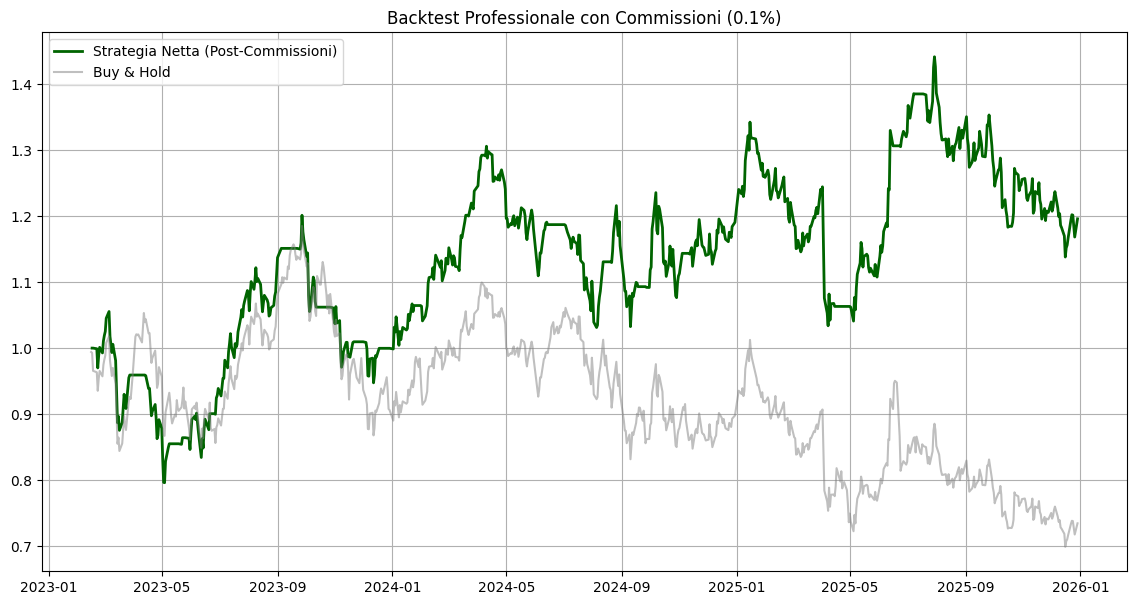

Sharpe Ratio della Strategia: 0.23
--- RISULTATI BACKTEST ---
Rendimento Finale Strategia: 19.58%
Rendimento Finale Buy & Hold: -26.54%


In [86]:
# --- 11. BACKTEST AVANZATO (COSTI E COMMISSIONI) ---

# Definiamo le commissioni (es. 0.1% per trade = 0.001)
# Per l'oro/stocks usa valori più bassi (es. 0.0005)
commissioni = 0.001 

backtest_df = pd.DataFrame({
    'Rendimento_Reale': y_test_log.flatten(),
    'Previsione_Modello': y_pred_log.flatten()
}, index=test_df.index[seq_length:])

# Generiamo i segnali
backtest_df['Segnale'] = np.where(backtest_df['Previsione_Modello'] > 0, 1, 0)

# Calcoliamo quando avviene un'operazione (cambio di segnale)
# Se oggi il segnale è 1 e ieri era 0, ho comprato.
backtest_df['Trade_Eseguito'] = backtest_df['Segnale'].diff().abs()

# Calcolo Rendimento Lordo
backtest_df['Rend_Lordo'] = backtest_df['Segnale'].shift(1) * backtest_df['Rendimento_Reale']

# Calcolo Costi: sottraiamo le commissioni ogni volta che facciamo un trade
backtest_df['Costi'] = backtest_df['Trade_Eseguito'] * commissioni
backtest_df['Rend_Netto'] = backtest_df['Rend_Lordo'] - backtest_df['Costi'].fillna(0)

# Equity Curves
backtest_df['Equity_Lorda'] = np.exp(backtest_df['Rend_Lordo'].cumsum())
backtest_df['Equity_Netta'] = np.exp(backtest_df['Rend_Netto'].cumsum())
backtest_df['Equity_BuyHold'] = np.exp(backtest_df['Rendimento_Reale'].cumsum())

# --- 12. PLOT E SHARPE RATIO ---
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['Equity_Netta'], label='Strategia Netta (Post-Commissioni)', color='darkgreen', lw=2)
plt.plot(backtest_df['Equity_BuyHold'], label='Buy & Hold', color='gray', alpha=0.5)
plt.title(f'Backtest Professionale con Commissioni ({commissioni*100}%)')
plt.grid(True)
plt.legend()
plt.show()

# Calcolo Sharpe Ratio (Rendimento / Rischio)
# Un valore > 1.0 è considerato buono, > 2.0 eccellente.
sharpe = (backtest_df['Rend_Netto'].mean() / backtest_df['Rend_Netto'].std()) * np.sqrt(252)
print(f"Sharpe Ratio della Strategia: {sharpe:.2f}")

# Calcolo del rendimento finale
final_return_strat = (backtest_df['Equity_Netta'].iloc[-1] - 1) * 100
final_return_bh = (backtest_df['Equity_BuyHold'].iloc[-1] - 1) * 100

print(f"--- RISULTATI BACKTEST ---")
print(f"Rendimento Finale Strategia: {final_return_strat:.2f}%")
print(f"Rendimento Finale Buy & Hold: {final_return_bh:.2f}%")